## **1)Data Loading & EDA**

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             confusion_matrix, classification_report)


Load CSV

In [79]:
df = pd.read_csv('/content/personality_dataset.csv')


Peek at the data

In [80]:
display(df.head())
df.info()
df.describe(include='all')


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
count,2837.000000,2827,2838.000000,2834.000000,2848,2823.000000,2835.000000,2900
unique,NaN,2,NaN,NaN,2,NaN,NaN,2
top,NaN,No,NaN,NaN,No,NaN,NaN,Extrovert
freq,NaN,1417,NaN,NaN,1441,NaN,NaN,1491
mean,4.505816,NaN,3.963354,3.000000,NaN,6.268863,3.564727,NaN
std,3.479192,NaN,2.903827,2.247327,NaN,4.289693,2.926582,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
25%,2.000000,NaN,2.000000,1.000000,NaN,3.000000,1.000000,NaN
50%,4.000000,NaN,3.000000,3.000000,NaN,5.000000,3.000000,NaN
75%,8.000000,NaN,6.000000,5.000000,NaN,10.000000,6.000000,NaN


## **2) Data Cleaning & Visualization**

Detect duplicates

In [81]:
dup_mask = df.duplicated(keep=False)
print(f"Found {dup_mask.sum()} duplicate row(s).")
display(df[dup_mask])

df = df.drop_duplicates(keep='first').reset_index(drop=True)


Found 703 duplicate row(s).


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
13,3.0,No,6.0,4.0,No,10.0,7.0,Extrovert
20,10.0,Yes,3.0,1.0,Yes,2.0,1.0,Introvert
23,9.0,Yes,2.0,2.0,Yes,1.0,0.0,Introvert
...,...,...,...,...,...,...,...,...
2884,11.0,Yes,0.0,2.0,Yes,3.0,1.0,Introvert
2890,8.0,Yes,2.0,0.0,Yes,1.0,2.0,Introvert
2891,6.0,Yes,3.0,1.0,Yes,5.0,1.0,Introvert
2892,9.0,Yes,2.0,0.0,Yes,1.0,2.0,Introvert


List Yes/No columns

In [82]:
yes_no_cols = ['Stage_fear', 'Drained_after_socializing']


Clean string columns

In [83]:
for c in yes_no_cols:
    df[c] = df[c].astype(str).str.strip().str.lower()


Map to numeric 1/0

In [84]:
mapping = {'yes': 1, 'no': 0}
for c in yes_no_cols:
    df[c] = df[c].map(mapping)


Verify mapping & catch unmapped

In [85]:
for c in yes_no_cols:
    unmapped = df.loc[df[c].isna(), c].unique()
    print(f"Unmapped in {c}:", unmapped)


Unmapped in Stage_fear: [nan]
Unmapped in Drained_after_socializing: [nan]


Plot distributions of Yes/No columns

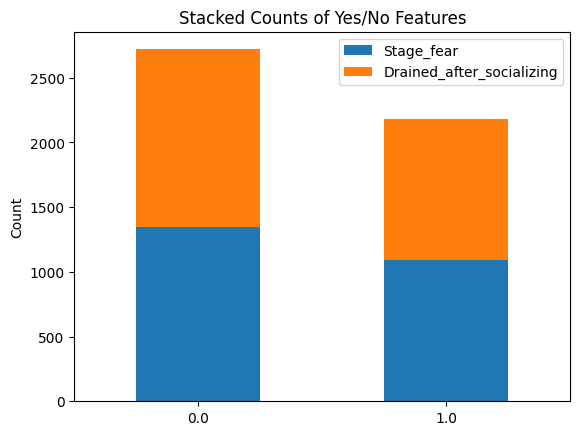

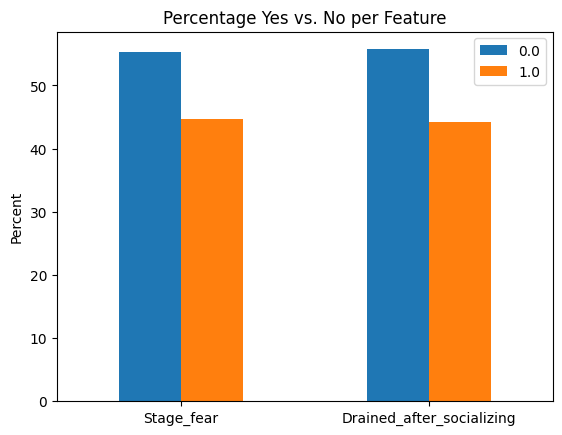

In [86]:
# raw counts stacked
counts = df[yes_no_cols].apply(lambda s: s.value_counts().sort_index())
counts.plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title('Stacked Counts of Yes/No Features')
plt.ylabel('Count')
plt.show()

# percentage side-by-side
pct = counts.div(counts.sum(axis=0), axis=1)*100
pct.T.plot.bar()
plt.xticks(rotation=0)
plt.title('Percentage Yes vs. No per Feature')
plt.ylabel('Percent')
plt.show()


Visualize the correlation between numeric features

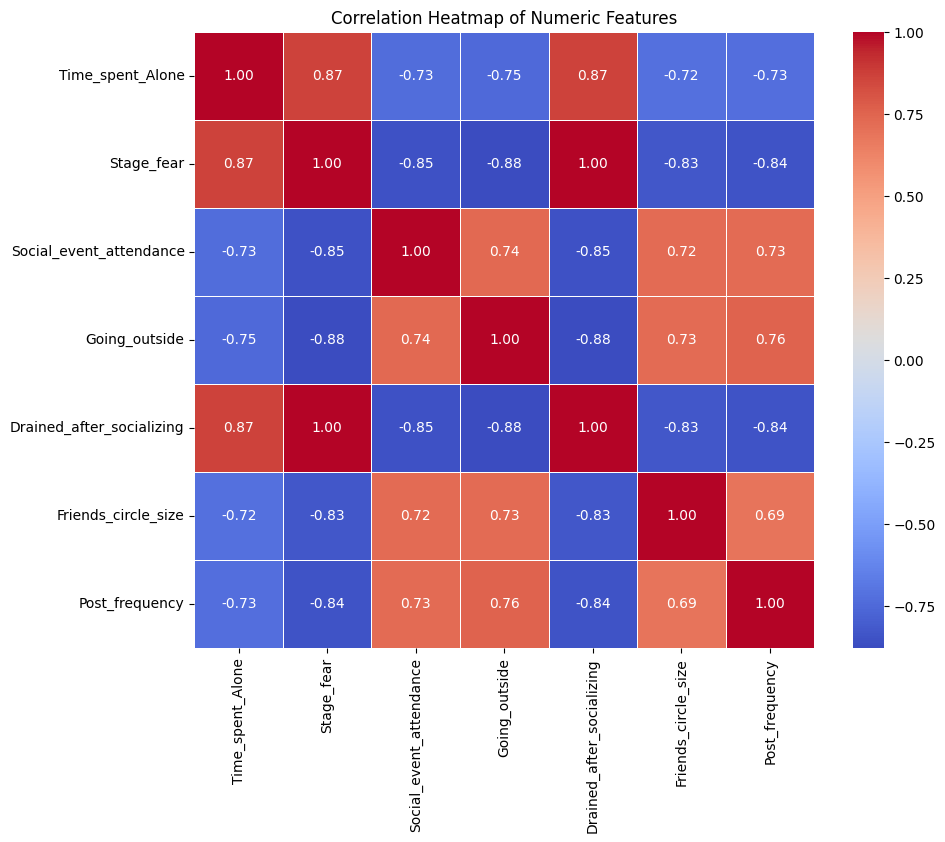

In [87]:
num_feats = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = df[num_feats].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


Boxplot to visualize distributions of numeric features

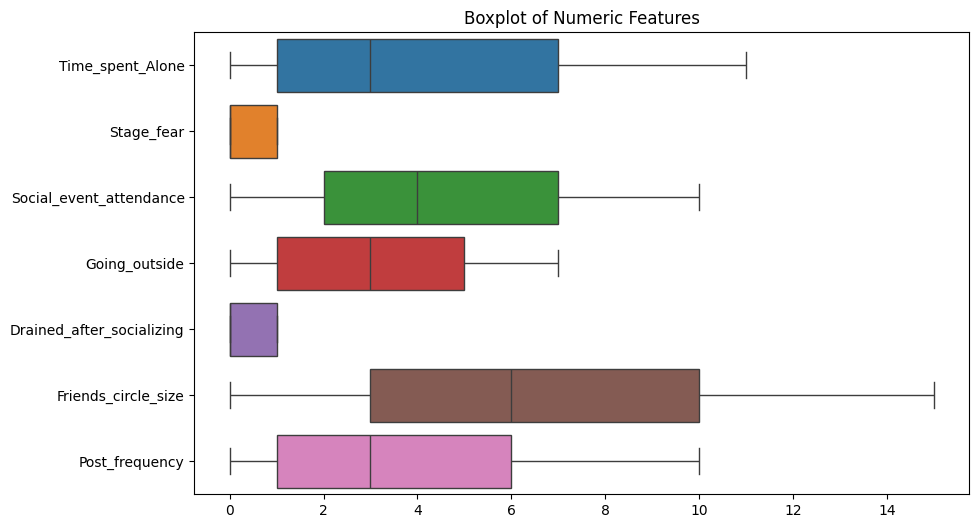

In [88]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[num_feats], orient='h')
plt.title('Boxplot of Numeric Features')
plt.show()


Visualize class distribution

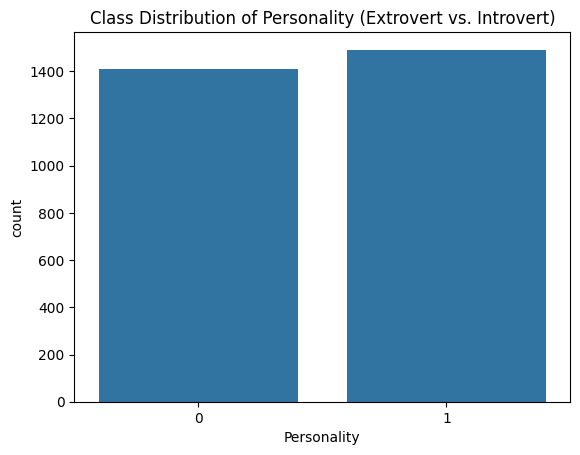

In [89]:
sns.countplot(x=y)
plt.title('Class Distribution of Personality (Extrovert vs. Introvert)')
plt.show()


## **3) Preprocessing & Modeling**

Define feature matrix X and target y

In [90]:
X = df.drop(columns=['Personality'])
y = df['Personality'].map({'Extrovert':1, 'Introvert':0})


Split into train/test

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Identify numeric vs. categorical features

In [92]:
num_feats = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_feats = [c for c in X.columns if c not in num_feats]


Build preprocessing pipelines

In [93]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
])


Assemble full pipeline with SMOTE + classifier

In [94]:
pipeline = ImbPipeline([
    ('preproc', preprocessor),
    ('smote',   SMOTE(random_state=42)),
    ('clf',     RandomForestClassifier(random_state=42))
])


Hyperparameter tuning

In [95]:
param_grid = {
    'clf__n_estimators':      [100, 300],
    'clf__max_depth':         [None, 10, 20],
    'clf__min_samples_leaf':  [1, 2, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
pipeline = grid.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}


## **4) Evaluation & Interpretation**

Cross-validated scores on training

In [96]:
scores = cross_val_score(pipeline, X_train, y_train,
                         cv=cv, scoring='accuracy')
print("Train CV accuracy:", scores.mean())


Train CV accuracy: 0.9283209885733428


Final fit & test evaluation

In [97]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("Test ROC AUC:   ", roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]))
print(classification_report(y_test, y_pred))


Test Accuracy:  0.9125248508946322
Test ROC AUC:    0.9618785774004759
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       219
           1       0.91      0.94      0.92       284

    accuracy                           0.91       503
   macro avg       0.91      0.91      0.91       503
weighted avg       0.91      0.91      0.91       503



Confusion matrix

Confusion Matrix:
 [[192  27]
 [ 17 267]]


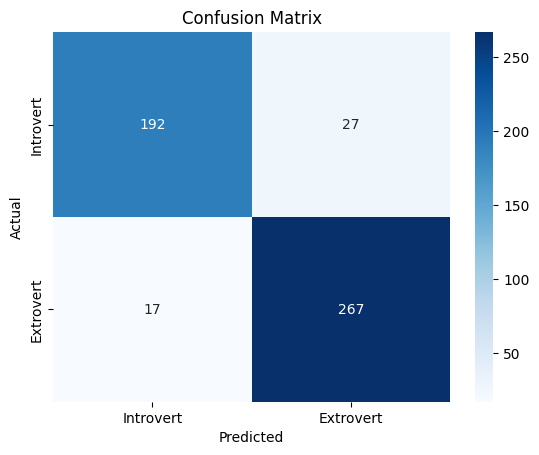

In [98]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualizing Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Introvert", "Extrovert"], yticklabels=["Introvert", "Extrovert"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Feature importance

,0
num__Drained_after_socializing,0.264965
num__Stage_fear,0.205860
num__Time_spent_Alone,0.186007
num__Social_event_attendance,0.150681
num__Going_outside,0.086268
num__Post_frequency,0.073568
num__Friends_circle_size,0.032651


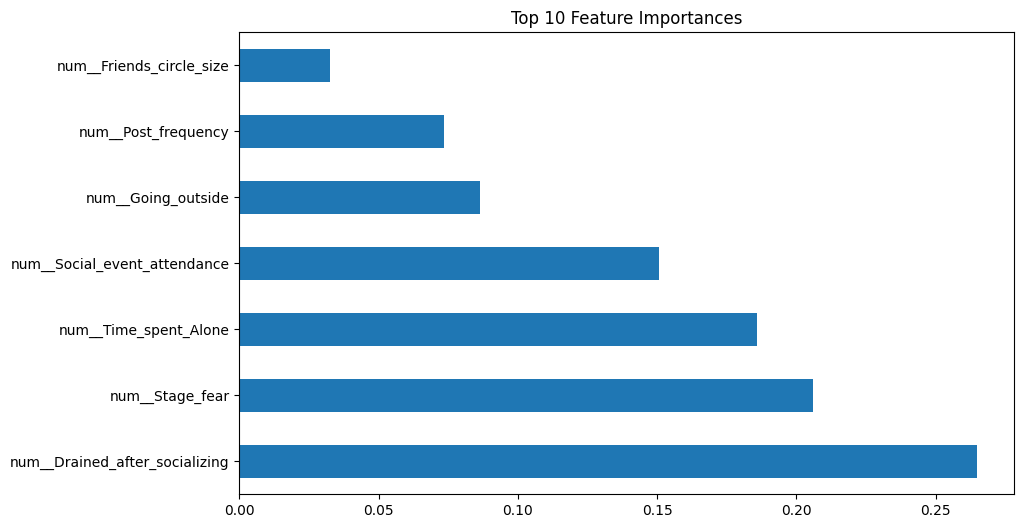

In [99]:
fi = pipeline.named_steps['clf'].feature_importances_
feats = (pipeline.named_steps['preproc']
         .get_feature_names_out())
imp_df = pd.Series(fi, index=feats).sort_values(ascending=False)
display(imp_df.head(10))

# Plot feature importance
imp_df.head(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.show()


In [100]:
import numpy as np
fi = pipeline.named_steps['clf'].feature_importances_
feats = (pipeline.named_steps['preproc']
         .get_feature_names_out())
imp_df = pd.Series(fi, index=feats).sort_values(ascending=False)
display(imp_df.head(10))


,0
num__Drained_after_socializing,0.264965
num__Stage_fear,0.205860
num__Time_spent_Alone,0.186007
num__Social_event_attendance,0.150681
num__Going_outside,0.086268
num__Post_frequency,0.073568
num__Friends_circle_size,0.032651


Final Evaluation

Test Accuracy: 0.9125248508946322
Test ROC AUC: 0.9618785774004759

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       219
           1       0.91      0.94      0.92       284

    accuracy                           0.91       503
   macro avg       0.91      0.91      0.91       503
weighted avg       0.91      0.91      0.91       503



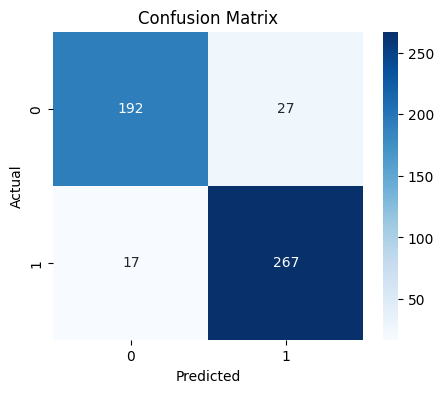

In [106]:
#Final Evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Save trained pipeline to file

In [107]:
import pickle
model_filename = 'personality_model.pkl'

# Save the trained pipeline to a .pkl file
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)

print(f"Model saved as {model_filename}")

Model saved as personality_model.pkl
